In [13]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '../'))  # return the projest's root folder
sys.path.append(project_root)
from utils import data_reshape, split_helper, load_parameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pandas as pd
import numpy as np
import pickle
from functools import partial
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [15]:
# BILSTM model -----------------------------------------------------------------------
# the input features of the BiLSTM model
features_bilstm = ['voltage', 'current', 'temperature', 'relativeTime']
labels_bilstm = ['capacity']

# load the model


# the BiLSTM model's input features need to be normalized
folder_path = 'data/data_nasa/'
path_dict = {'train': f'{folder_path}train.csv',
             'valid': f'{folder_path}valid.csv',
             'test': f'{folder_path}test.csv'}
data_dict = {key: pd.read_csv(path) for key, path in path_dict.items()}
data = pd.concat(data_dict, axis=0)
scaler = MinMaxScaler()
data[features_bilstm] = scaler.fit_transform(data[features_bilstm])
# split tha dataset into train, valid, test
unique_cycles = data['cycle'].unique()
# Example: 70% train+val, 30% test
trainval_cycles, test_cycles = train_test_split(
    unique_cycles, test_size=0.2, random_state=42
)
test_bilstm = data[data['cycle'].isin(test_cycles)]
# BILSTM model ------------------------------------------------------------------------

In [16]:
# LightGBM model -----------------------------------------------------------------------
# the input features of the LightGBM model
params = load_parameters('model_lightgbm/parameters.yaml')
features_lgb = params.features
labels_lgb = params.labels

# load the model
# with open('model_lightgbm/model_pruning/pruned_nasa_3features_first20_01886500/pruned_110trees_0199.pkl', 'rb') as file:
#     model_lgb = pickle.load(file)
with open('model_lightgbm/model_nasa/nasa_3features_first20_01886500.pkl', 'rb') as file:
    model_lgb = pickle.load(file)

# the testing data
test_lgb = pd.read_csv('data/data_nasa/test.csv')
# LightGBM model -----------------------------------------------------------------------

dataset: nasa
features: ['voltage', 'temperature', 'discharge_voltage_rate']
labels: ['capacity']
data_groupby: ['cycle', 'capacity']
num_trials: 500
overlap_mode: all
split_size: 20
multi_split_size: [5, 10, 15, 20, 40, 50, 70, 100]
num_restricted: 20


In [17]:
data_groupby = ['cycle', 'capacity']
# step_len_list = [5, 10, 15, 20, 30, 40, 50, 70, 100]
step_len_list = [20]
# step_len_list = [5, 10, 15, 20, 30, 40, 50]

# get the group size
group_sizes = test_lgb.groupby(data_groupby).size()
max_group_length, min_group_length = group_sizes.max(), group_sizes.min()
print(f"--group length: max={max_group_length}, min={min_group_length}\n")
fixed_group_length = min_group_length

# test and save the result onto dataframe
columns = ['model', 'step_length', 'ordinal', 'MAE', 'loss']
result = pd.DataFrame(columns=columns)

--group length: max=360, min=175



In [18]:
# BILSTM model ----------------------------------------------------
model_bilstm_path = 'model_bilstm/model_nasa/'
model_bilstm_dict = {
    '5': f'{model_bilstm_path}nasa_len5_1007.keras',
    '10': f'{model_bilstm_path}nasa_len10_1014.keras',
    '15': f'{model_bilstm_path}nasa_len15_0462.keras',
    # '20': f'{model_bilstm_path}nasa_len20_0295.keras',
    '20': f'download/ST_BiLSTM_st.keras',
    '30': f'{model_bilstm_path}nasa_len30_0527.keras',
    '40': f'{model_bilstm_path}nasa_len40_0871.keras',
    '50': f'{model_bilstm_path}nasa_len50_0334.keras',
}
for step_len in step_len_list:
    # load the bilstm model
    if str(step_len) in model_bilstm_dict:
        model_bilstm = load_model(model_bilstm_dict[str(step_len)])
    else:
        continue
    
    # generate testing data for different step length
    max_ordinal = fixed_group_length//step_len
    if max_ordinal==0:
        continue

    for ordinal in range(1, max_ordinal+1):      
        # generate testing data for different ordinal number
        test_seg_bilstm = pd.DataFrame()
        for idx, group in test_bilstm.groupby(data_groupby):
            # get the testing data by slicing
            start = (ordinal-1)*step_len
            end = ordinal*step_len
            test_seg_bilstm = pd.concat([test_seg_bilstm, group.iloc[start:end]])

        # reshpe the data
        test_samples_bilstm, test_targets_bilstm = data_reshape(test_seg_bilstm,step_len,features_bilstm,labels_bilstm)

        # test the model
        test_loss_bilstm, test_mae_bilstm = model_bilstm.evaluate(test_samples_bilstm, test_targets_bilstm, verbose=0)

        # record the result
        new_row = pd.DataFrame({'model': ['bilstm'], 
                                'step_length': [step_len],
                                'ordinal': [ordinal],
                                'MAE': [test_mae_bilstm],
                                'loss': [test_loss_bilstm]
                                })
        result = pd.concat([result, new_row], ignore_index=True)
# BILSTM model ----------------------------------------------------


2025-01-29 11:32:44.744838: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/tmp/ipykernel_904/1650493260.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, new_row], ignore_index=True)


In [19]:
# LightGBM model ----------------------------------------------------
for step_len in step_len_list:  
    # generate testing data for different step length
    max_ordinal = fixed_group_length//step_len
    if max_ordinal==0:
        continue

    for ordinal in range(1, max_ordinal+1):    
        # generate testing data for different ordinal number
        test_seg_lgb = pd.DataFrame()
        for idx, group in test_lgb.groupby(data_groupby):
            # get the testing data by slicing
            start = (ordinal-1)*step_len
            end = ordinal*step_len
            test_seg_lgb = pd.concat([test_seg_lgb, group.iloc[start:end]])

        # process the data
        test_seg_lgb = split_helper(test_seg_lgb, data_groupby, features_lgb, labels_lgb)
        test_x = test_seg_lgb[features_lgb]
        test_y = test_seg_lgb[labels_lgb]

        # test the model
        pred_lgb = model_lgb.predict(test_x)
        # test_mse_lgb = np.mean((test_y - pred_lgb) ** 2)
        test_mae_lgb = mean_absolute_error(test_y, pred_lgb)

        # record the result
        new_row = pd.DataFrame({'model': ['lgb'], 
                                'step_length': [step_len],
                                'ordinal': [ordinal],
                                'MAE': [test_mae_lgb],
                                'loss': [0]
                                })
        result = pd.concat([result, new_row], ignore_index=True)
# LightGBM model ----------------------------------------------------

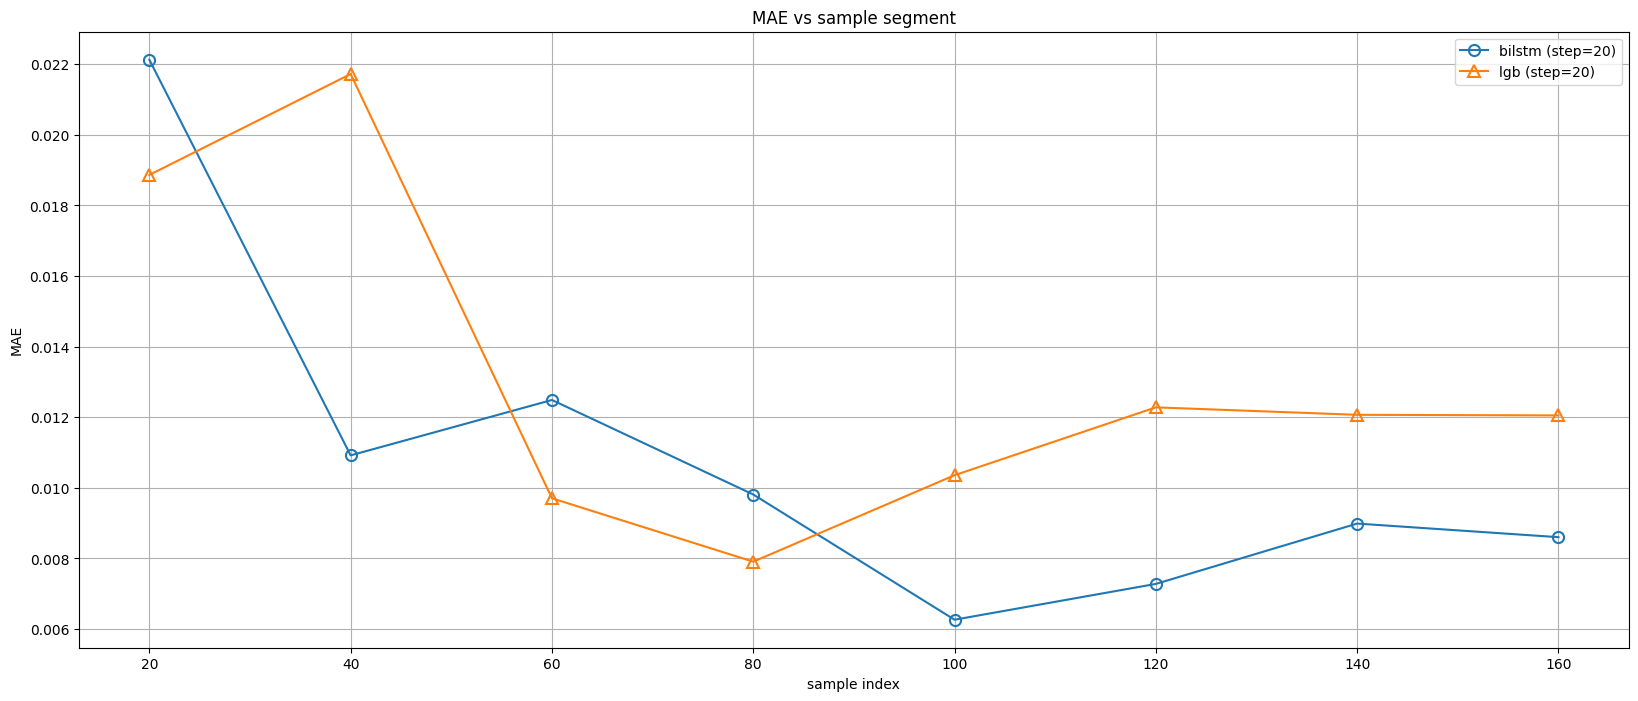

In [20]:
# Visualize the result
plt.figure(figsize=(20, 8))  # Create a single figure
plt.title("MAE vs sample segment")  # Set the title of the plot
plt.xlabel("sample index")  # Label for the x-axis
plt.ylabel("MAE")  # Label for the y-axis

# Define markers for each model
model_markers = {
    'bilstm': 'o',
    'lgb': '^',
}

# Iterate through each model
for model in result['model'].unique():
    marker = model_markers.get(model, 'o')  # Get the marker for the model, default to 'o'

    # Iterate through each step_length
    for step_len in step_len_list:
        # Filter data for the current step_length and model
        subset = result[(result['step_length'] == step_len) & (result['model'] == model)]

        x = subset['ordinal'] * step_len
        y = subset['MAE']
        plt.plot(
            x, y,
            label=f'{model} (step={step_len})',
            marker=marker,  # Use the marker for the model
            linestyle='-',
            markersize=8,
            markerfacecolor='none', 
            markeredgewidth=1.5 
        )

plt.legend()
plt.grid()
plt.show()
